# Dreamnet Dreamer

This algorithm takes in an encoding from the autoencoder along with steering data and a time difference to dertermine what the next image in the series is. Eventually this will include IMU data to deal with acceleration and a more dynamic state

In [4]:
import tensorflow as tf
print(tf.__version__)
tf.config.experimental.list_physical_devices('GPU')

2.0.0


[]

(480, 848, 3)


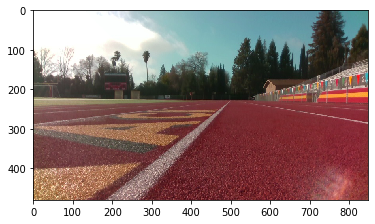

In [5]:
# verify the image data directory
import os
data_directory = "/media/michael/BigMemory/datasets/jetsoncar/backup1-12-20/data/dataset/"
os.listdir(data_directory)[:10]

import matplotlib.pyplot as plt
img = plt.imread(os.path.join(data_directory + "/color_images", os.listdir(data_directory + "/color_images")[0]))
print(img.shape)
plt.imshow(img)

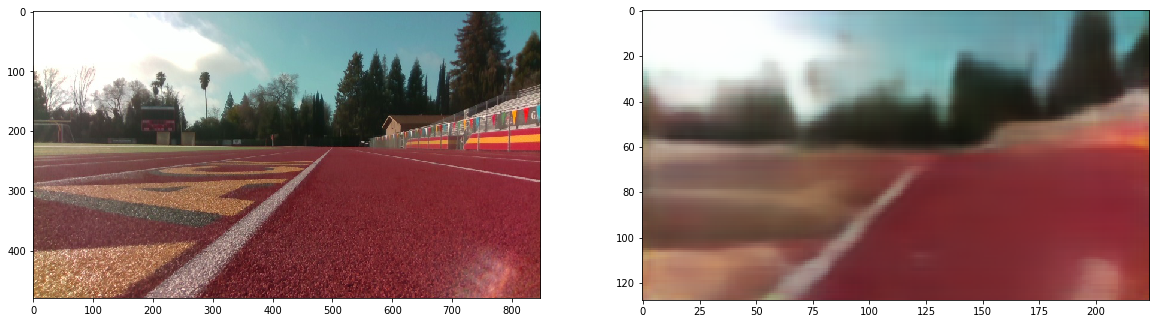

In [173]:
# lost the encoder and decoder
encoder = tf.keras.models.load_model('dreamnet_encoder')
decoder = tf.keras.models.load_model('dreamnet_decoder')

import numpy as np

# create a simple function to preprocess images before putting them into the neural network
def preprocess(image):
    return np.expand_dims(tf.image.resize(image/255.0,(128,224)), axis=0)

encoding = encoder.predict(preprocess(img))
decoding = decoder.predict(encoding)

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow(np.squeeze(decoding))

## Prepare Data
For predicitng the next action and image we need to create a nework that combines last steering angle and speed with the last encoding to try to predict the next encoding it will. This means the data is time dependant and due to the nature of the encoding we should not need to use and generator. This also make the data preparation easier

In [181]:
x_train_img = None
x_train_state = None # state data such as steering, throttle etc. 
y_train = None # target predicted encoding

x_test_img = None 
x_test_state = None # state data such as steering, throttle etc. 
y_test = None # target predicted encoding

validation_split = 0.2
max_time_diff = 0.2 # maximum time differemce before next image is rejected

import csv, random, itertools
# function for getting the image that corresponds to the next image. Still need to make sure time difference is acceptable!
def peek(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first, itertools.chain([first], iterable) # itertools puts the entry back into the generator

with open(os.path.join(data_directory, "tags.csv")) as tags:
    csv_reader = csv.reader(tags, delimiter=',')
    for i, row in enumerate(csv_reader):
        if i > 0: # skip the first row since it just has the headers
            current_time = float(row[0])
            current_throttle = float(row[1])
            current_steering = float(row[2])
            current_img = plt.imread(os.path.join(data_directory + "/color_images", str(current_time) + ".jpg"))
            
            future_row = peek(csv_reader)
            if future_row is None:
                print("Finished loading data!")
                continue
            future_time = float(future_row[0][0])
            future_throttle = float(future_row[0][1])
            future_steering = float(future_row[0][2])
            future_img = plt.imread(os.path.join(data_directory + "/color_images", str(future_time) + ".jpg"))
            
            # check to make sure there is not too big of a time difference
            if future_time - current_time < max_time_diff:
                if random.random() > 1.0 - validation_split: 
                    # going into test set
                    if(x_test_img is None):
                        x_test_img = np.array(encoder.predict(preprocess(current_img)))
                        x_test_state = np.array([[current_throttle, current_steering]])
                        y_test = encoder.predict(preprocess(future_img))
                    else:
                        x_test_img = np.append(x_test_img, encoder.predict(preprocess(current_img)), axis=0)
                        x_test_state = np.vstack((x_test_state, [[current_throttle, current_steering]]))
                        y_test = np.vstack((y_test, encoder.predict(preprocess(future_img))))
                else:
                    # going into training set
                    if(x_train_img is None):
                        x_train_img = np.array(encoder.predict(preprocess(current_img)))
                        x_train_state = np.array([[current_throttle, current_steering]])
                        y_train = encoder.predict(preprocess(future_img))
                    else:
                        x_train_img = np.vstack((x_train_img, encoder.predict(preprocess(current_img))))
                        x_train_state = np.vstack((x_train_state, [[current_throttle, current_steering]]))
                        y_train = np.vstack((y_train, encoder.predict(preprocess(future_img))))
            else:
                print("Data ignored over time diff")
        else:
            print(row)

print("\nTrain data shapes:")
print(x_train_img.shape)
print(x_train_state.shape)
print(y_train.shape)
print("\nTest data shapes:")
print(x_test_img.shape)
print(x_test_state.shape)
print(y_test.shape)

['time_stamp', 'raw_steering', 'raw_speed', 'max_speed', 'absolute_max_speed', 'imu_calibration', 'quaternion_x', 'quaternion_y', 'quaternion_z', 'quaternion_w', 'angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z']
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time diff
Data ignored over time di

## Dreamnet Dream Model

Define the model

In [235]:
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

# Define the convnet that handles conv block
conv_in = tf.keras.Input(shape=(8,14,16))
x = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(conv_in)
# x = tf.keras.layers.BatchNormalization()(x)
conv_out = tf.keras.layers.Flatten()(x)

conv_model = tf.keras.models.Model(inputs=conv_in, outputs=conv_out)
conv_model.summary()

# Define the FCNN that handles state data
dense_in = tf.keras.Input(shape=(2))
x = tf.keras.layers.Dense(8, activation='relu')(dense_in)
dense_out = tf.keras.layers.Dense(16, activation='relu')(x)

dense_model = tf.keras.models.Model(inputs=dense_in, outputs=dense_out)
dense_model.summary()

# create the combined model
combined_in = tf.keras.layers.concatenate([dense_model.output, conv_model.output])
x = tf.keras.layers.Dense(1800, activation='relu')(combined_in)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(8*14*16, activation='relu')(x)
x = tf.keras.layers.Reshape((8,14,16))(x)
combined_out = tf.keras.layers.Conv2D(16, (3,3), activation="linear", padding="same")(x)

combined_model = tf.keras.models.Model(inputs=[conv_in, dense_in], outputs=combined_out)
combined_model.summary()

# save the graph as a png
tf.keras.utils.plot_model(combined_model, "dreamnet.png")

Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 8, 14, 16)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 8, 14, 16)         2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 14, 16)         64        
_________________________________________________________________
flatten_27 (Flatten)         (None, 1792)              0         
Total params: 2,384
Trainable params: 2,352
Non-trainable params: 32
_________________________________________________________________
Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 2)]               0         
_____________________________________

In [236]:
# should have just used validation split and shuffle in fit instead of splitting dataset up earlier
combined_model.compile(optimize="adam", loss="mse", metrics=['acc'])
history = combined_model.fit(x=[x_train_img, x_train_state], 
                   y=y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=([x_test_img, x_test_state], y_test))

Train on 3883 samples, validate on 956 samples
Epoch 1/10
3883/3883 [==============================] - 4s 1ms/sample - loss: 0.0304 - acc: 0.3150 - val_loss: 0.0500 - val_acc: 0.4874
Epoch 2/10
3883/3883 [==============================] - 4s 956us/sample - loss: 0.0119 - acc: 0.5349 - val_loss: 0.0317 - val_acc: 0.5692
Epoch 3/10
3883/3883 [==============================] - 4s 973us/sample - loss: 0.0092 - acc: 0.5841 - val_loss: 0.0180 - val_acc: 0.6039
Epoch 4/10
3883/3883 [==============================] - 4s 958us/sample - loss: 0.0079 - acc: 0.6095 - val_loss: 0.0103 - val_acc: 0.6152
Epoch 5/10
3883/3883 [==============================] - 4s 959us/sample - loss: 0.0070 - acc: 0.6274 - val_loss: 0.0068 - val_acc: 0.6442
Epoch 6/10
3883/3883 [==============================] - 4s 958us/sample - loss: 0.0064 - acc: 0.6423 - val_loss: 0.0066 - val_acc: 0.6421
Epoch 7/10
3883/3883 [==============================] - 4s 957us/sample - loss: 0.0059 - acc: 0.6540 - val_loss: 0.0062 - val_a

## Test and save the model

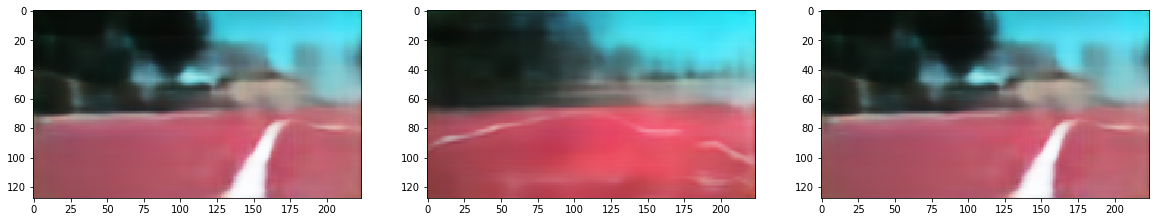

In [253]:
test_index = random.randint(0, x_test_img.shape[0])

# get the current values to test
current_encoding = np.expand_dims(x_test_img[test_index], axis=0)
current_state = np.expand_dims(x_test_state[test_index], axis=0)
current_decoding = decoder.predict(current_encoding)

# predict the next encoding
predicted_future_encoding = combined_model.predict([current_encoding, current_state])
predicted_future_decoding = decoder.predict(predicted_future_encoding)

# actual next encoding
actual_future_encoding = np.expand_dims(y_test[test_index], axis=0)
actual_future_decoding = decoder.predict(actual_future_encoding)

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,3,1)
plt.imshow(np.squeeze(current_decoding))
fig.add_subplot(1,3,2)
plt.imshow(np.squeeze(predicted_future_decoding))
fig.add_subplot(1,3,3)
plt.imshow(np.squeeze(actual_future_decoding))

In [148]:
#save the model
combined_model.save("dreamnet_state_predictor")

INFO:tensorflow:Assets written to: dreamnet_state_predictor/assets
